In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import os

In [2]:
# DEFINE PATHS ON YOUR LOCAL DEVICE
# dataRoot --> Folder that you have the DataSET
dataRoot = '../../nuScenes_dataSet'
# path --> Direction to save image patches
path = 'C:/Users/manue/Desktop/Student/Thesis/nuScenes_dataSet/color_patches'

In [3]:
# Change the dataRoot --> Folder that you have the DataSET
# Change verbose to True to print the message status
nusc = NuScenes(version='v1.0-mini', dataroot=dataRoot, verbose=False)

# nuScenes
## 1. Scenes

Take a look at the scenes that are loaded in the database. This example dataset has 10 scenes, but there are many more to come. In the next cell, the metadata is observed. Thereafter, a single scene is saved into a variable `my_scene[i]`, in which the index `i` indicates the scene to access.  
For more information, check the source code of the function [`list_scenes()`](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L792)  

**Render a Scene:** It is possible to render a video of a certain scene.  
[`render_scene_channel`](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L1706) Method to show in video all the 6 Camera inputs.   
[`render_scene`](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L1592) Method to show in video just 1 Camera channel.  



_Still to solve_: How to don't show the objects annotated. There are a set of instructions inside of the functions previously mentioned, that render the annotation boxes into each sample. This is done through the method [`box.render_cv2`](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L1675) but it should imply to modify that function, because there are no arguments that would disable this action.


In [4]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [5]:
my_scene = nusc.scene[0]

# Get the number of scene and description
my_scene_name = my_scene['name']
my_scene_desc = my_scene['description']
print(my_scene_name, '-->',my_scene_desc)
# Check if the description has Left or Right
if 'turn left' in my_scene_desc: 
    print('Turn_left = TRUE')
else:
    print('Turn_left = FALSE')
    

scene-0061 --> Parked truck, construction, intersection, turn left, following a van
Turn_left = TRUE


In [8]:
# RENDER A SCENE
# out_path --> Direction to save render scenes
out_path = 'C:/Users/manue/Desktop/Student/Thesis/nuScenes_dataSet/Scene_videos/'
out_path = out_path + my_scene_name + '.avi'

video_render = my_scene['token']
# channel --> CAM_FRONT_LEFT, CAM_FRONT_RIGHT, CAM_BACK, CAM_BACK_LEFT, CAM_BACK_RIGHT
channel = 'CAM_FRONT'
im_size = (400, 225) #(640, 360)
nusc.render_scene_channel(scene_token=video_render, channel=channel, imsize=im_size, out_path=out_path)
# nusc.render_scene(scene_token=video_render, imsize=im_size, out_path=out_path)

## 2. Sample

A sample is defined as an *annotated keyframe of a scene at a given timestamp*. A keyframe is a frame where the time-stamps of data from all the sensors should be very close to the time-stamp of the sample it points to.
Now, let us look at the first annotated sample in this scene.  


In [9]:
first_sample_token = my_scene['first_sample_token']
# nusc.render_sample(first_sample_token)

In [10]:
my_sample = nusc.get('sample', first_sample_token)
# my_sample

In [11]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
# cam_front_data

## 3. ego_pose
It contains information about the location (Translation) and the orientation (Rotation) of the ego vehicle frame, with respect to the global coordinate system.  
Acces to the ego_pose dictionary --> `nusc.ego_pose[i]`  
Get ego_pose from each sensor --> Use ego_pose_token from the sampling data of the sensor.

_Problem_: It is unclear how to split the ego_pose into each scene. For example, the mini-set has 10 scenes, and 31206 ego_pose are reported. If all these values are plotted, 10 different curves will be obtained in the same graph.  
The amount of ego_pose is not spread evenly throughout the number of scenes (i.e. 31206 ego_pose / 10 scenes).

In [ ]:
# nusc.ego_pose[0]

In [ ]:
# nusc.get('ego_pose', cam_front_data['ego_pose_token'])

(2600, 3)


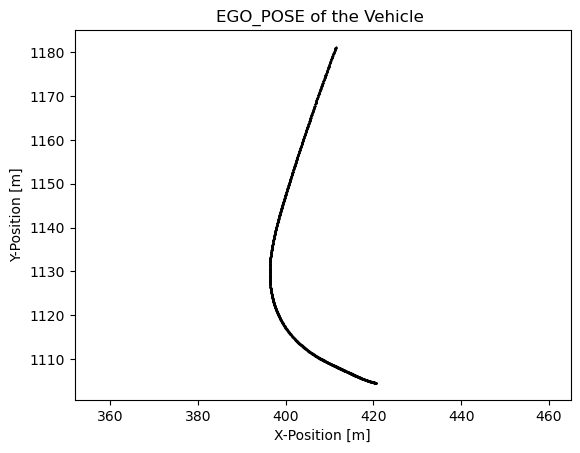

In [6]:
N = 2600
pose = []
for i in range(N):
    # Extract TRANSLATION-key to get the position of the vehicle
    pose.append(nusc.ego_pose[i]['translation'])
pose_arr = np.array(pose)
print(pose_arr.shape)
x_coord = pose_arr[:,0]
y_coord = pose_arr[:,1]

fig, ax = plt.subplots()
ax.plot(x_coord, y_coord, ".k", markersize=0.75)

ax.axis("equal")
plt.title("EGO_POSE of the Vehicle ")
plt.xlabel("X-Position [m]")
plt.ylabel("Y-Position [m]")
plt.show()

# CAN bus expansion

It contains low-level vehicle data about the vehicle route, IMU, pose, steering angle feedback, battery, brakes, gear position, signals, wheel speeds, throttle, torque of the wheels. To use this expanxion, it is necessary to download the required files from the [nuScenes](https://www.nuscenes.org/download) website.  

[`Tutorial can bus`](https://www.nuscenes.org/nuscenes?tutorial=can-bus)  -- 
[`Can bus expansion`](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/can_bus/README.md)

In [7]:
nusc_can = NuScenesCanBus(dataroot='../../nuScenes_dataSet')

In [8]:
scene_name = 'scene-0061'
# nusc_can.print_all_message_stats(scene_name)

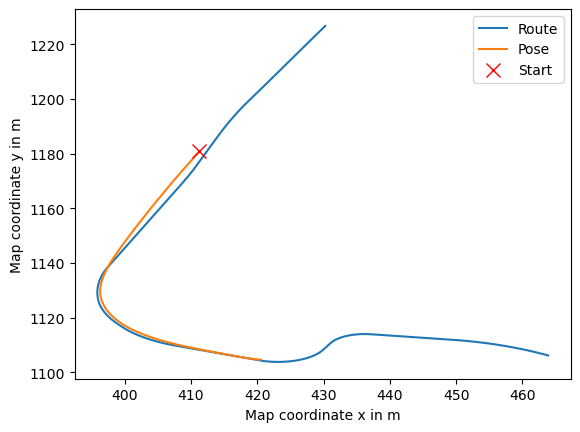

In [9]:
nusc_can.plot_baseline_route(scene_name)

In [10]:
# INSPECT THE POSE INFORMATION
# position = nusc_can.get_messages(scene_name, 'pose')
# position[0]

In [37]:
position = nusc_can.get_messages(scene_name, 'pose')

# FREQUENCY --> 50 Hz
# GENERATE A VECTOR [time   x   y   vel  accel  z  orientation ]
# The velocity is in the ego vehicle frame --> Only in first coordiante 
position = np.array([(m['utime'], m['pos'][0], m['pos'][1], m['vel'][0], m['accel'][0], m['pos'][2], m['orientation'][0], m['orientation'][3]) for m in position])

# NORMALIZE TIME  --> Subtract initial timestamp Then convert from u-seconds to seconds
# With the difference you get rid of the information related to days, hours, minutes
position[:,0] = (position[:,0] - position[0,0]) / 1e6


I'm creating a time vector with evenly spread numbers to match the sampling frequency of Simulink. As a first experiment I us the same frequency as nuScenes data (50Hz) and I match the number in Prescan. 
1. Create time vector.
2. Crop it to the size of the data coming from nuscenes. 
3. Normalize values of position
   - Coordinate (0,0) will be the minimum point to reach = Subtract minimum value
   - Coordinate (0,0) will be the initial point = Subtract the first value 
4. PositionZ will be always zero. For prescan experiment we assume a flat surface 
5. Concatenate time + posX + posY + posZ
6. Save into a matlabfile. Why? Synthetic data is being generated in the software SIEMENS Prescan, using the same trajectory as the dataset.

In [38]:
import scipy.io
pos_x = position[:,1]
min_x = pos_x.min()*np.ones(position.shape[0])
pos_x = pos_x - min_x
pos_x = np.reshape(pos_x, (position.shape[0], 1))

pos_y = position[:,2]
min_y = pos_y.min()*np.ones(position.shape[0])
pos_y = pos_y - min_y
pos_y = np.reshape(pos_y, (position.shape[0], 1))

vel_ego = position[:,3]
vel_ego = np.reshape(vel_ego, (position.shape[0], 1))

w_ego = position[:,6]
w_ego = np.reshape(w_ego, (position.shape[0], 1))

yaw_ego = position[:,7]
yaw_ego = np.reshape(yaw_ego, (position.shape[0], 1))

# DOWNSAMPLE
new_freq = 20
downsamp = int(50/new_freq)
x = []
y = []
vel = []
yaw = []
w = []

for i in range (position.shape[0]):
    if i % downsamp == 0:
        x.append(pos_x[i])
        y.append(pos_y[i])
        vel.append(vel_ego[i])
        w.append(w_ego[i])
        yaw.append(yaw_ego[i])

x = np.asarray(x)
y = np.asarray(y)
vel = np.asarray(vel)
w = np.asarray(w)
yaw = np.asarray(yaw)
z = np.zeros((x.shape[0],1))

start=0
step=1/new_freq
num=x.shape[0]
time_vec=np.arange(0,num)*step+start
time_vec = np.reshape(time_vec,(num,1))

pose_mat = np.concatenate((time_vec, x, y, z, vel, w, yaw), axis = 1)
file_name = 'data.mat'
scipy.io.savemat(file_name, {'data': pose_mat})

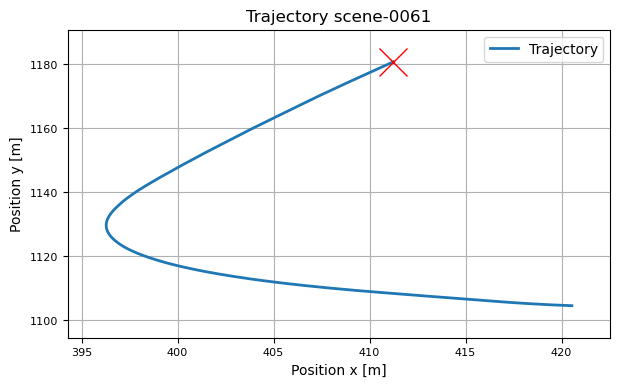

In [12]:
# PLOTTING TRAJECTORY
time_pose = position[:,0]
pos_x = position[:,1]
pos_y = position[:,2]

# PLOTTING TRAJECTORY SIGNAL
fig, ax = plt.subplots(1, figsize=(7, 4), sharex=True)
ax.plot(pos_x, pos_y, linewidth = 2, label='Trajectory')
ax.plot(pos_x[0], pos_y[1], marker="x", markersize=20, markeredgecolor="red")

ax.set_xlim([pos_x.min()-2, pos_x.max()+2])
ax.set_ylim([pos_y.min()-10, pos_y.max()+10])
ax.tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax.set_ylabel('Position y [m]')
ax.set_xlabel('Position x [m]')
title = "Trajectory " + scene_name
ax.title.set_text(title)
ax.legend()
ax.grid()

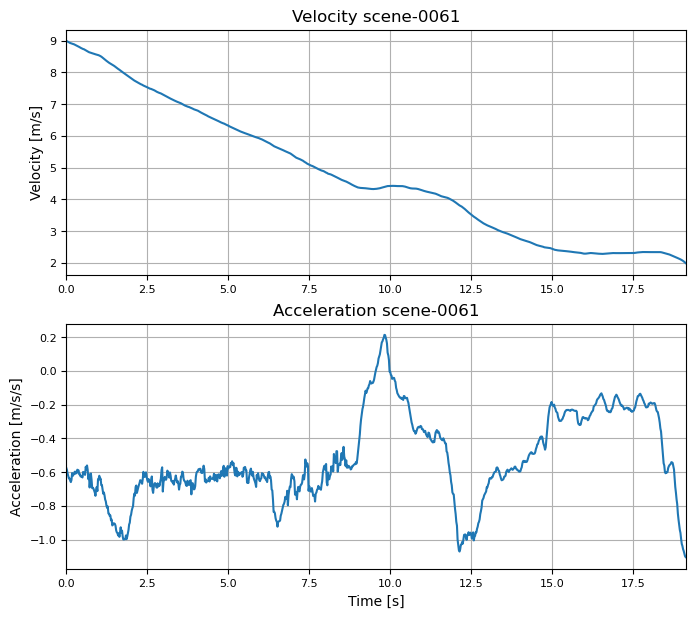

In [13]:
# PLOTTING VELOCITY AND ACCELERATION

acceleration_x = position[:,4]
velocity_sc = position[:, 3]

fig, ax = plt.subplots(2,1, figsize=(8, 7), sharex=True)

# VELOCITY
ax[0].plot(time_pose, velocity_sc, label='Velocity')
ax[0].set_xlim([time_pose[0], time_pose[-1]])
ax[0].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[0].set_ylabel('Velocity [m/s]')
title = "Velocity " + scene_name
ax[0].title.set_text(title)
ax[0].grid()

# ACCELERATION
ax[1].plot(time_pose, acceleration_x, label='Acceleration')
ax[1].set_xlim([time_pose[0], time_pose[-1]])
ax[1].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Acceleration [m/s/s]')
title = "Acceleration " + scene_name
ax[1].title.set_text(title)
ax[1].grid()

In [14]:
# ACCELERATION LABEL
# [acc, dec, const]

acceleration = [0,0,0]
acc_100 = [0,0,0] 
total = 0

# Hyperparameter 
acc_lim = 0.004
downsample = 1
for i in range(velocity_sc.shape[0] - downsample):
    if i % downsample == 0:
        delta_vel = velocity_sc[i + downsample] - velocity_sc[i]
        if delta_vel >= acc_lim:
            acceleration[0] += 1
        if delta_vel <= -acc_lim:
            acceleration[1] += 1
        if (delta_vel > -acc_lim) and (delta_vel < acc_lim):
            acceleration[2] += 1
        total += 1


acc_100[0] = 100 * acceleration[0]/total
acc_100[1] = 100 * acceleration[1]/total
acc_100[2] = 100 * acceleration[2]/total

if all(i < 42 for i in acc_100):
    max_value = max(acc_100)
    index = acc_100.index(max_value)
    print(index)

print ("accel:", acceleration[0], "\tdecel:", acceleration[1], "\tconst:", acceleration[2])
print ("accel:", acc_100[0], "\tdecel:", acc_100[1], "\tconst:", acc_100[2])

accel: 13 	decel: 698 	const: 226
accel: 1.3874066168623265 	decel: 74.49306296691569 	const: 24.119530416221984


## Vehicle Monitor Information

In order to create the classification of trajectory, the information related to the turning direction should be encoded. For that, the directory of Vehicle Monitor gives acces to some relevant data described in the following lines.  

  Frequency: 2Hz

- `left_signal`: Left turning signal as an integer, 0 (inactive) or 1 (active).
- `right_signal`: Right turning signal as an integer, 0 (inactive) or 1 (active).
- `steering`: Steering angle in degrees at a resolution of 0.1 in range [-780, 779.9].
- `Brake`: Braking pressure in bar. An integer in range [0, 126].
- `brake_switch` Brake switch as an integer, 1 (pedal not pressed), 2 (pedal pressed) or 3 (pedal confirmed pressed).
- `gear_position`: The gear position as an integer, typically 0 (parked) or 7 (driving).
- `throttle`: Throttle pedal position as an integer in range [0, 1000].
- `vehicle_speed`: Vehicle speed in km/h at a resolution of 0.01.

### Steer Angle Feedback
Another library which gives access to the steering angle but at higher sampling frequency. It can be concluded that both curves for steering are exactly the same, just the resolution and sampling time is different. For simplicity, it could be easier to use the`steering` key from the `Vehicle Monitor Information` directory.
Frequency: 100 Hz

In [15]:
# VEHICLE MONITOR INFORMATION 
vehicle_monitor = nusc_can.get_messages(scene_name, 'vehicle_monitor')
# Generate a vector --> [Time   Left_signal   Right_signal   Steering]
vehicle_monitor = np.array([(m['utime'], m['left_signal'], m['right_signal'], m['steering']) for m in vehicle_monitor])

# Normalize time
vehicle_monitor[:,0] = (vehicle_monitor[:,0] - vehicle_monitor[0,0]) / 1e6

# CREATE VARIABLES FOR VEHICLE INFO
time_vm = vehicle_monitor[:,0]
left_signal = vehicle_monitor[:,1]
right_signal = vehicle_monitor[:,2]
steering_angle = vehicle_monitor[:,3]

In [16]:
# STEER ANGLE FEEDBACK DIRECTORY 
steerangle_fb = nusc_can.get_messages(scene_name, 'steeranglefeedback')
steerangle_fb = np.array([(m['utime'], m['value']) for m in steerangle_fb])

# Normalize time
steerangle_fb[:,0] = (steerangle_fb[:,0] - steerangle_fb[0,0]) / 1e6

# CREATE VARIABLES FOR VEHICLE INFO
time_sf = steerangle_fb[:,0]
steering_angle_fb = steerangle_fb[:,1]

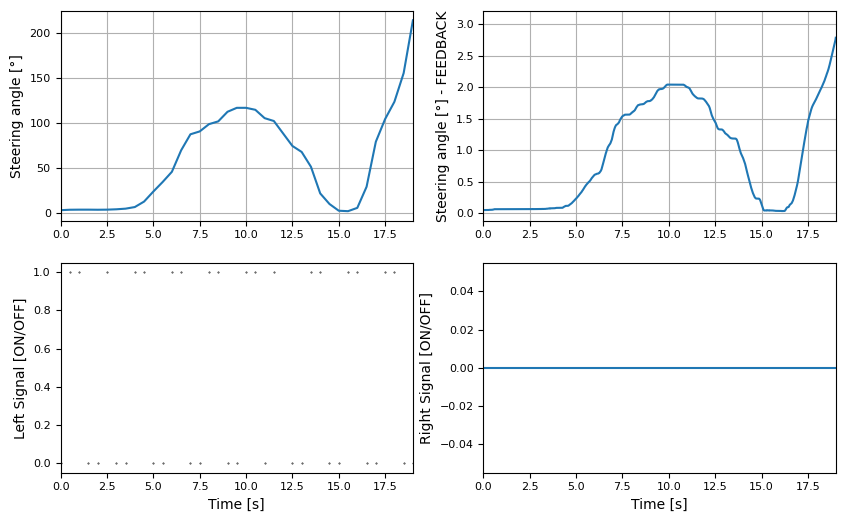

In [17]:
# PLOTTING STEERING ANGLE INFORMATION
fig, ax = plt.subplots(2,2, figsize=(10, 6), sharex=True)

ax[0,0].plot(time_vm, steering_angle, label='Steering angle')
ax[0,0].set_xlim([time_vm[0], time_vm[-1]])
ax[0,0].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[0,0].set_ylabel('Steering angle [°]')
ax[0,0].grid()

ax[0,1].plot(time_sf, steering_angle_fb, label='Steering angle')
ax[0,1].set_xlim([time_sf[0], time_sf[-1]])
ax[0,1].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[0,1].set_ylabel('Steering angle [°] - FEEDBACK')
ax[0,1].grid()

ax[1,0].plot(time_vm, left_signal, ".k", markersize=0.75, label='Left_signal')
ax[1,0].set_xlim([time_vm[0], time_vm[-1]])
ax[1,0].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_ylabel('Left Signal [ON/OFF]')

ax[1,1].plot(time_vm, right_signal, label='Right_signal')
ax[1,1].set_xlim([time_vm[0], time_vm[-1]])
ax[1,1].tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('Right Signal [ON/OFF]')
plt.show()

Turning left at time: 9.499289


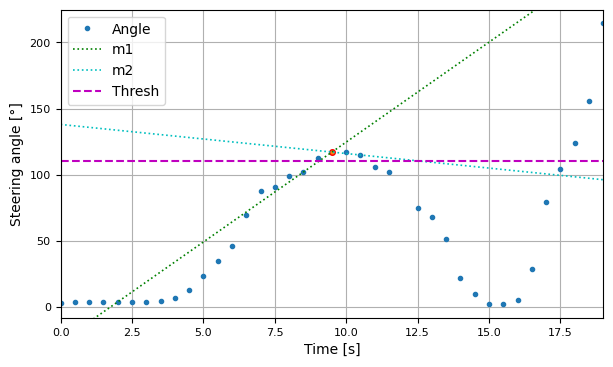

In [18]:
# LEFT TURN 
turn_thresh = 110

max_index = np.where(steering_angle >= turn_thresh)
for i in range(max_index[0].shape[0]):
    arr_idx = max_index[0][i]
    # BREAK in case the maximum is 1 second before the last sample
    if (arr_idx + 2 >= steering_angle.shape[0]) or (arr_idx <= 1):
        continue

    # Previous neighbouring point 
    prev = steering_angle[arr_idx] - steering_angle[arr_idx - 2]
    # Next neighbouring point 
    post = steering_angle[arr_idx + 2] - steering_angle[arr_idx]
    # print("prev:",prev," post:",post)

    if (prev >0 and post<0) or (post >0 and prev<0):
        print ("Turning left at time:", time_vm[arr_idx])
        x_max = time_vm[arr_idx]
        y_max = steering_angle[arr_idx]
        
        m_1 = (steering_angle[arr_idx] - steering_angle[arr_idx - 2]) /(time_vm[arr_idx] - time_vm[arr_idx - 2])
        x_1 = time_vm[arr_idx - 2]
        y_1 = steering_angle[arr_idx - 2]
        
        m_2 = (steering_angle[arr_idx + 2] - steering_angle[arr_idx]) /(time_vm[arr_idx + 2] - time_vm[arr_idx])
        x_2 = time_vm[arr_idx]
        y_2 = steering_angle[arr_idx]
        break

line_x = np.array([0,20])
line1_y = m_1*(line_x - x_1) + y_1
line2_y = m_2*(line_x - x_2) + y_2
fig, ax = plt.subplots(1, figsize=(7, 4), sharex=True)
# PLOTTING SIGNALS
ax.plot(time_vm, steering_angle, '.', label='Angle')
ax.plot(x_max, y_max, marker="o", markersize=4, markeredgecolor="red")

ax.plot(line_x, line1_y, color = 'g', linewidth=1.2, linestyle = ':', label='m1')
ax.plot(line_x, line2_y, color = 'c', linewidth=1.2, linestyle = ':', label='m2')

ax.set_xlim([time_vm[0], time_vm[-1]])
ax.set_ylim([steering_angle.min() - 10, steering_angle.max()+10])
ax.axhline(y = turn_thresh, color = 'm', linewidth=1.5, linestyle = 'dashed', label="Thresh")    
ax.tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax.set_ylabel('Steering angle [°]')
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()

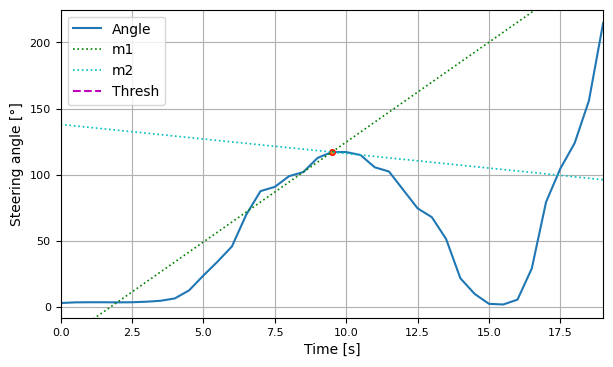

In [19]:
# RIGHT TURN 
turn_thresh = -110

max_index = np.where(steering_angle <= turn_thresh)
for i in range(max_index[0].shape[0]):
    arr_idx = max_index[0][i]
    # BREAK in case the maximum is 1 second before the last sample
    if (arr_idx + 2 >= steering_angle.shape[0]) or (arr_idx <= 1):
        continue

    # Previous neighbouring point 
    prev = steering_angle[arr_idx] - steering_angle[arr_idx - 2]
    # Next neighbouring point 
    post = steering_angle[arr_idx + 2] - steering_angle[arr_idx]
    # print("prev:",prev," post:",post)

    if (prev >0 and post<0) or (post >0 and prev<0):
        print ("Turning left at time:", time_vm[arr_idx])
        x_max = time_vm[arr_idx]
        y_max = steering_angle[arr_idx]
        
        m_1 = (steering_angle[arr_idx] - steering_angle[arr_idx - 2]) /(time_vm[arr_idx] - time_vm[arr_idx - 2])
        x_1 = time_vm[arr_idx - 2]
        y_1 = steering_angle[arr_idx - 2]
        
        m_2 = (steering_angle[arr_idx + 2] - steering_angle[arr_idx]) /(time_vm[arr_idx + 2] - time_vm[arr_idx])
        x_2 = time_vm[arr_idx]
        y_2 = steering_angle[arr_idx]
        break

line_x = np.array([0,20])
line1_y = m_1*(line_x - x_1) + y_1
line2_y = m_2*(line_x - x_2) + y_2
fig, ax = plt.subplots(1, figsize=(7, 4), sharex=True)
# PLOTTING SIGNALS
ax.plot(time_vm, steering_angle, linewidth = 1.5, label='Angle')
ax.plot(x_max, y_max, marker="o", markersize=4, markeredgecolor="red")

ax.plot(line_x, line1_y, color = 'g', linewidth=1.2, linestyle = ':', label='m1')
ax.plot(line_x, line2_y, color = 'c', linewidth=1.2, linestyle = ':', label='m2')

ax.set_xlim([time_vm[0], time_vm[-1]])
ax.set_ylim([steering_angle.min() - 10, steering_angle.max()+10])
ax.axhline(y = turn_thresh, color = 'm', linewidth=1.5, linestyle = 'dashed', label="Thresh")    
ax.tick_params(axis='both', which='both', labelsize=8, labelbottom=True)
ax.set_ylabel('Steering angle [°]')
ax.set_xlabel('Time [s]')
ax.legend()
ax.grid()

## Trajectory Pictures

## Scaled Trajectory Pictures

In [24]:
# OBTAIN WIDTH AND HEIGHT OF A PICTURE
# Virtual spacing --> Avoid black_pixels in the edge
offset = 4
half_offset = offset/2

w = position[:,1].max()-position[:,1].min() + offset
h = position[:,2].max()-position[:,2].min() + offset
print('width=', w,'   height=',h)

width= 28.2554050584194    height= 80.16192287952049


## Encoding velocity with colors
Steps:
1. `max_vel`: Variable to define the maximum velocity of the car
2. `Hue` --> The color is set in an inverse HSV color model, allowing to create a function dependent on the velocity. The meaning of inverse means that the lowest velocity `v = 0m/s` will have assigned a value of 180, closer to the blue spectrum, i.e. the faster the car is, the more red will be the color.   
3. `cv2.threshold()` --> A mask is created in order to keep the white background, and identify the pixels where the trajectory was plotted. The threshold function should be executed in gray_scale (2 channels), but the or logical operation should have 3 channels.
4. `cv2.bitwise_or()` --> Trajectory in RGB + White background

In [27]:
# PRINT A PICTURE IN HSV FORMAT
# ENCODE TIME AS SATURATION
size_picture = (100,100)
# Scale --> Change size of trajectory and avoid getting picture index out of bounds
scale = 0.9

prop_w = scale*size_picture[0]/w
prop_h = scale*size_picture[1]/h

velocity_map = 255*np.ones((size_picture[1],size_picture[0],3), np.uint8)
velocity_map[:,:,1] = 0
downsamp = 2
max_vel = position[:, 3].max()

time_max = position[:, 0].max()
min_sat = 75

for i in range (position.shape[0]):
    if i % downsamp == 0:
        x = int(prop_w*(position[i,1] - position[:,1].min())) + offset
        y = int(prop_h*(h - (position[i,2] - position[:,2].min()))) + offset
        
        # Save information for starting point
        if i == 0:
            # Cross
            start_point_l1 = (int(x - half_offset), int(y + half_offset))
            end_point_l1 = (int(x + half_offset), int(y - half_offset))
            start_point_l2 = (int(x - half_offset), int(y - half_offset))
            end_point_l2 = (int(x + half_offset), int(y + half_offset))  
            # Circle
            center_coordinates = (x, y)
        
        # PICTURE IN HSV format
        hue = int((-120/max_vel)*(position[i, 3]) + 120)
        # sat = int(((255 - min_sat)/time_max)*(position[i, 0]) + min_sat) # Min at starting
        sat = int(((min_sat - 255)/time_max)*(position[i, 0]) + 255) # Max at starting
        velocity_map[y, x] = (hue,sat,255)

rgb = cv2.cvtColor(velocity_map, cv2.COLOR_HSV2BGR)
cv2.imshow('Blank', rgb)
cv2.waitKey(0) 

# #closing all open windows 
cv2.destroyAllWindows()

[Python f-strings](https://realpython.com/python-f-strings/)   String formating: "%04d" where the 4 is the constant length of the number, i.e. it will always print 4 digits. 
In the next cell, it the maximum and minimum value for the steering angle in the whole set of scenes is found. First it is obtained the maximum for each scene, which later will be useful to define if there was a turn to the left or the right. 

`blacklist`: There are some scenes that doesn't have CAN Bus information, another of them, report to have zero-size array, hence, another conditional should be added. 

A new function callled `picture_patch` is defined, in which the patch_color is generated in the same way as it was shown before. 

## LEFT / RIGHT TURN
1. Looking for all the values that are maximum than $threshold = 100$. 
2. Evaluate the sign of the slope $S_{t} - S_{t-1}$ and $S_{t+1} - S_{t}$. One should be positive and the other one should be negative, otherwise it is not a turn. 